# UBC Scientific Software Seminar

October 6, 2017

* Feature engineering
    * Titles and decks
    * One-hot encoding of categorical data
    * Fill in missing age data
* Random forest classifier

Last time we introduced [Kaggle](https://www.kaggle.com/) competitions and started with the [Titanic dataset](https://www.kaggle.com/c/titanic). Today we're going to try and extract additional features from the data and use a random forest classifier to make survival predictions. Let's go!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Feature engineering

[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) (or feature extraction) is the process of using domain knowledge to create new features from the data to use in machine learning algorithms. For the Titanic dataset, we're going to extract the title from the name of each person, we'll get the deck from the cabin number, and fill in missing data for age.

Let's start by importing the data and let's take a quick look to remind ourselves about what we're dealing with.

In [2]:
titanic = pd.read_csv('train.csv')

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have 891 samples (ie. passengers) and 11 features (notice that the "Survival" column is the target).

Notice also that the column "PassengerId" is not useful since this is a unique (arbitray) id number.

In [5]:
titanic.drop('PassengerId',axis=1,inplace=True)

### Gender

The gender variable is entered as a string. Let's convert it to numeric (male=0 or female=1) using the [`map` pandas Series method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html). The `map` method applies a dictionary, dataframe or function to each entry in the column (ie. pandas Series) to create a new column.

In [6]:
titanic['Gender'] = titanic['Sex'].map({'male': 0, 'female': 1})

In [7]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### Titles

We'll use the [regular expression](https://en.wikipedia.org/wiki/Regular_expression) Python package to search for a title in each name. The `search` method returns the matches of the regular expression in a group object and we retrieve the first match with the `group` method.

The regular expression `[a-zA-Z]+\.` we use below means "match a pattern consisting of one or more letters in the set [a-zA-Z] (ie. any upper or lower case letter) followed by a period".

In [8]:
import re

In [9]:
def get_title(name):
    return re.search('[a-zA-Z]+\.',name).group(0)
    
titanic['Title'] = titanic['Name'].map(get_title)

In [10]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr.
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs.
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs.
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr.


Let's take a look at the different titles of passengers.

In [11]:
titanic['Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Lady.          1
Sir.           1
Don.           1
Jonkheer.      1
Capt.          1
Ms.            1
Countess.      1
Mme.           1
Name: Title, dtype: int64

Let's look at the survival rate by title and notice that there were 7 reverends (Rev.) but none survived.

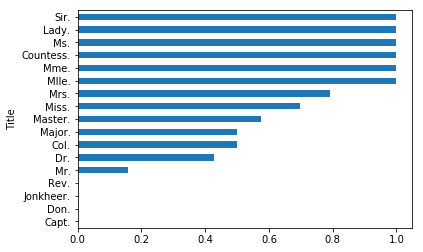

In [12]:
(titanic.groupby('Title')['Survived'].sum() / titanic.groupby('Title').size()).sort_values().plot(kind='barh')

Let's group similar titles together. For example, Ms., Miss. and Mlle. are very similar as well as Mrs. and Mme. 

In [13]:
def title_transform(title):
    if title in ['Mr.','Mrs.','Miss.','Master.','Rev.','Dr.']:
        return title
    elif title == 'Mme.':
        return 'Mrs.'
    elif title in ['Mlle.','Ms.']:
        return 'Miss.'
    elif title in ['Capt.', 'Col.','Major.']:
        return 'Military'
    elif title in ['Jonkheer.','Lady.','Sir.','Don.','Countess.']:
        return 'Royalty'
    else:
        return 'Rare'

titanic['Title'] = titanic['Title'].map(title_transform)

Let's turn the title column (which is a catergorial variable without a natural order) into a numeric vector. This process is called [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). We'll use the [pandas `get_dummies`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) function which searches the column and collects all the unique values and creates a coilumn for each.

In [14]:
titles_df = pd.get_dummies(titanic['Title'])

In [15]:
titles_df.head()

,Dr.,Master.,Military,Miss.,Mr.,Mrs.,Rev.,Royalty
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0


Let's save the titles in a list to use later.

In [16]:
titles_list = list(titles_df.columns)

In [17]:
titles_list

['Dr.', 'Master.', 'Military', 'Miss.', 'Mr.', 'Mrs.', 'Rev.', 'Royalty']

Finally, let's add these new features to our data.

In [18]:
titanic = pd.concat([titanic,titles_df],axis=1)

In [19]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Gender,Title,Dr.,Master.,Military,Miss.,Mr.,Mrs.,Rev.,Royalty
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,0,Mr.,0,0,0,0,1,0,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,1,Mrs.,0,0,0,0,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,1,Miss.,0,0,0,1,0,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,1,Mrs.,0,0,0,0,0,1,0,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,0,Mr.,0,0,0,0,1,0,0,0


### Missing age

There are 177 samples with missing data in the "Age" column. Let's fill in the missing data using the median age by title.

In [20]:
titanic[titanic['Age'].isnull()].shape

(177, 21)

In [21]:
ages = titanic[titanic['Age'].notnull()]

In [22]:
median_age_by_title = ages.groupby('Title')['Age'].median()

In [23]:
median_age_by_title

Title
Dr.         46.5
Master.      3.5
Military    56.0
Miss.       21.0
Mr.         30.0
Mrs.        35.0
Rev.        46.5
Royalty     40.0
Name: Age, dtype: float64

In [24]:
missing_ages = titanic[titanic['Age'].isnull()]['Title'].map(median_age_by_title)

In [25]:
titanic['Age'] = titanic['Age'].fillna(missing_ages)

In [26]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
Gender      891 non-null int64
Title       891 non-null object
Dr.         891 non-null uint8
Master.     891 non-null uint8
Military    891 non-null uint8
Miss.       891 non-null uint8
Mr.         891 non-null uint8
Mrs.        891 non-null uint8
Rev.        891 non-null uint8
Royalty     891 non-null uint8
dtypes: float64(2), int64(5), object(6), uint8(8)
memory usage: 97.5+ KB


### Deck

The "Cabin" column includes a letter which (presumably) indicates a location on the ship. Let's call the location "Deck" and we'll assign "X" to those passengers not staying in a cabin.

In [27]:
titanic['Cabin'].fillna('X', inplace=True)

We extract the Deck letter by using the map method with an anonmymous (lambda) function which extracts the first letter inthe string.

In [28]:
titanic['Deck'] = titanic['Cabin'].map(lambda x: x[0])

Let's look at the survival rate by "Deck".

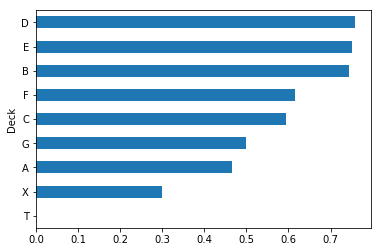

In [29]:
(titanic.groupby('Deck')['Survived'].sum() / titanic.groupby('Deck')['Survived'].size()).sort_values().plot(kind='barh');

In [30]:
titanic.groupby('Deck').size().sort_values()

Deck
T      1
G      4
F     13
A     15
E     32
D     33
B     47
C     59
X    687
dtype: int64

This again is catergorical data and so we use the pandas `get_dummies` function as we did for the "Title" column above.

In [31]:
deck_df = pd.get_dummies(titanic['Deck'],prefix='Deck')

In [32]:
titanic = pd.concat([titanic,deck_df],axis=1)

In [33]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_X
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,...,X,0,0,0,0,0,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,C,0,0,1,0,0,0,0,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,...,X,0,0,0,0,0,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,C,0,0,1,0,0,0,0,0,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,...,X,0,0,0,0,0,0,0,0,1


### Select features for the model

I feel that we have extracted quite a bit from the data. I don't know what to do with "Ticket" and I think "Embarked" is not so useful. Let's look at all our columns and select those we want to use in our model.

In [34]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 31 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       891 non-null object
Embarked    889 non-null object
Gender      891 non-null int64
Title       891 non-null object
Dr.         891 non-null uint8
Master.     891 non-null uint8
Military    891 non-null uint8
Miss.       891 non-null uint8
Mr.         891 non-null uint8
Mrs.        891 non-null uint8
Rev.        891 non-null uint8
Royalty     891 non-null uint8
Deck        891 non-null object
Deck_A      891 non-null uint8
Deck_B      891 non-null uint8
Deck_C      891 non-null uint8
Deck_D      891 non-null uint8
Deck_E      891 non-null uint8
Deck_F      891 non-null uint8
Deck_G      891 

In [35]:
features = ['Pclass','Age', 'SibSp', 'Parch','Fare','Gender',
            'Dr.', 'Master.','Military', 'Miss.', 'Mr.', 'Mrs.', 'Rev.', 'Royalty',
            'Deck_A','Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T','Deck_X']

In [36]:
X = titanic.loc[:,features]

In [37]:
y = titanic['Survived']

In [38]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Gender,Dr.,Master.,Military,Miss.,...,Royalty,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_X
0,3,22.0,1,0,7.2500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Random forests

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest):

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

Let's import the random forest class from scikit-learn and fit a model to our data.

In [39]:
from sklearn.ensemble import RandomForestClassifier as RFC

### Train test split

We would like to tune the parameters in the model to obtain optimal performance however we shouldn't test our model on the training set. It's customary to randomly split the data into a set for training the model and a set for testing the model. We'll use the `train_test_split` function in scikit-learn to split our dataset.

In [40]:
from sklearn.model_selection import train_test_split as train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Fit and score the model

Fitting and testing the data is now as simple as...

In [42]:
clf = RFC(n_estimators=100)

In [43]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [44]:
clf.score(X_test,y_test)

0.8044692737430168

The classifier has a method to measure the importance of each of the features. It seems that "Fare", "Age" and "Gender" are the most important features for this model.

In [45]:
feature_importance = pd.Series(clf.feature_importances_,index=X.columns)

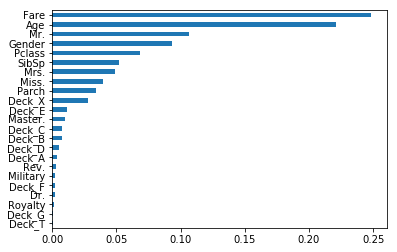

In [46]:
feature_importance.sort_values().plot(kind='barh');

## Make a submission

Let's make a submission with the model we've trained.

In [47]:
test = pd.read_csv('test.csv')

In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We have to do some preprocessing first: change the "Sex" column to numeric "Gender" column, get titles, fill in missing data, etc.

In [49]:
test['Title'] = test['Name'].map(get_title)
test['Title'] = test['Title'].map(title_transform)
test_titles_df = pd.get_dummies(test['Title'])
test = pd.concat([test,test_titles_df],axis=1)

test['Gender'] = test['Sex'].map({'male': 0, 'female': 1})

test['Cabin'].fillna('X', inplace=True)
test['Deck'] = test['Cabin'].map(lambda x: x[0])
deck_df = pd.get_dummies(test['Deck'],prefix='Deck')
test = pd.concat([test,deck_df],axis=1)

missing_ages_test = test[test['Age'].isnull()]['Title'].map(median_age_by_title)
test['Age'] = test['Age'].fillna(missing_ages_test)

median_fare_by_title = test.groupby('Title')['Fare'].median()
missing_fares = test[test['Fare'].isnull()]['Title'].map(median_fare_by_title)
test['Fare'].fillna(missing_fares,inplace=True)

submit = test.loc[:,features]

In [50]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
Pclass      418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Gender      418 non-null int64
Dr.         418 non-null uint8
Master.     418 non-null uint8
Military    418 non-null uint8
Miss.       418 non-null uint8
Mr.         418 non-null uint8
Mrs.        418 non-null uint8
Rev.        418 non-null uint8
Royalty     0 non-null float64
Deck_A      418 non-null uint8
Deck_B      418 non-null uint8
Deck_C      418 non-null uint8
Deck_D      418 non-null uint8
Deck_E      418 non-null uint8
Deck_F      418 non-null uint8
Deck_G      418 non-null uint8
Deck_T      0 non-null float64
Deck_X      418 non-null uint8
dtypes: float64(4), int64(4), uint8(15)
memory usage: 32.3 KB


Notice there is no "Royalty" or "Deck T" in the test set. Let's fill them with zeros.

In [51]:
submit['Royalty'] = 0
submit['Deck_T'] = 0

In [52]:
predictions = clf.predict(submit)

In [53]:
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'], 'Survived': pd.Series(predictions)})

In [54]:
submission.to_csv('submission.csv', index=False)

My best submission scored 0.7655. The best scores are around 85%. We need some new ideas to get a better score!